In [29]:
from pandas import read_csv
from datetime import datetime
import numpy as np
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)

# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution.csv')


                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


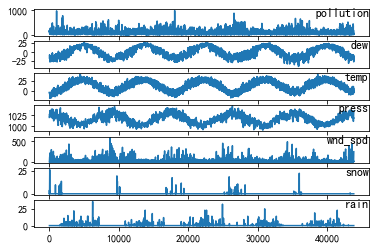

In [30]:
from pandas import read_csv
# 绘制训练曲线
import matplotlib.pyplot as plt
import matplotlib
#指定默认字体
matplotlib.rcParams['font.sans-serif'] = ['SimHei'] 
matplotlib.rcParams['font.family']='sans-serif'
#解决负号'-'显示为方块的问题
matplotlib.rcParams['axes.unicode_minus'] = False

# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values # 转化成np数组去绘制
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [31]:
import pandas as pd
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1] # 拿到变量个数
    df = pd.DataFrame(data) # 构造成pd数组
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1): # n_in,n_in-1...1
        cols.append(df.shift(i)) # 添加n_in期的数据(经过前移n_in期)
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [32]:
from sklearn.preprocessing import LabelEncoder # 包和模块
from sklearn.preprocessing import MinMaxScaler
#数据处理
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4]) # 将分类特征转换
values = values.astype("float32")
scaler = MinMaxScaler(feature_range=(0,1))
values_scaled = scaler.fit_transform(values)
# 构造时序序列
reframed = series_to_supervised(values_scaled,1,1) # 

In [37]:
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,0.129779,0.352941,0.245902,0.527273,0.666667,0.002290,0.000000,0.0,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0
2,0.148893,0.367647,0.245902,0.527273,0.666667,0.003811,0.000000,0.0,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0
3,0.159960,0.426471,0.229508,0.545454,0.666667,0.005332,0.000000,0.0,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0
4,0.182093,0.485294,0.229508,0.563637,0.666667,0.008391,0.037037,0.0,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0
5,0.138833,0.485294,0.229508,0.563637,0.666667,0.009912,0.074074,0.0,0.109658,0.485294,0.213115,0.563637,0.666667,0.011433,0.111111,0.0


In [5]:
# 输出只保留我们要预测的下一期的整个序列
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True) # 只保留要预测的序列

In [6]:
reframed_value = reframed.values 
n_train_hours = 365*24 # 训练集总数
train = reframed_value[:n_train_hours,:]
test = reframed_value[n_train_hours:,:]
# 分割成输入和输出
X_train ,y_train = train[:,:-1],train[:,-1]
X_test, y_test = test[:,:-1],test[:,-1]
# 转换成LSTM的输入格式[samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1])) # 拉成3维的
X_test = X_test.reshape((X_test.shape[0],1,X_test.shape[1]))
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(8760, 1, 8) (35039, 1, 8) (8760,) (35039,)


In [7]:
from keras.models import Sequential
from keras.layers import Dense,LSTM
# 模型的构建
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1],8) ))
model.add(LSTM(50,input_shape=(X_train.shape[1],8)))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(X_train,y_train, epochs=20,batch_size=72,validation_data=(X_test,y_test),verbose=2)

Using TensorFlow backend.
f:\conda\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
f:\conda\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
f:\conda\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
f:\conda\envs\py36\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Pas

f:\conda\envs\py36\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
f:\conda\envs\py36\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
f:\conda\envs\py36\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
f:\conda\envs\py36\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:544: FutureWarning: P


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 8760 samples, validate on 35039 samples
Epoch 1/20
 - 2s - loss: 0.0556 - val_loss: 0.0379
Epoch 2/20
 - 1s - loss: 0.0182 - val_loss: 0.0146
Epoch 3/20
 - 1s - loss: 0.0150 - val_loss: 0.0150
Epoch 4/20
 - 1s - loss: 0.0145 - val_loss: 0.0133
Epoch 5/20
 - 1s - loss: 0.0145 - val_loss: 0.0132
Epoch 6/20
 - 1s - loss: 0.0143 - val_loss: 0.0135
Epoch 7/20
 - 1s - loss: 0.0143 - val_loss: 0.0132
Epoch 8/20
 - 1s - loss: 0.0144 - val_loss: 0.0138
Epoch 9/20
 - 1s - loss: 0.0143 - val_loss: 0.0144
Epoch 10/20
 - 1s - loss: 0.0144 - val_loss: 0.0136
Epoch 11/20
 - 1s - loss: 0.0141 - val_loss: 0.0131
Epoch 12/20
 - 1s - loss: 0.0145 - val_loss: 0.0131
Epoch 13/20
 - 1s - loss: 0.0144 - val_loss: 0.0131
Epoch 14/20
 - 1s - loss: 0.0142 - val_loss: 0.0131
Epoch 15/20
 - 1s - loss: 0.0141 - val_loss: 0.0142
Epoch 16/20
 - 1s - loss: 0.0143 - val_loss: 0.0131
Epoch 17/20
 - 1s - loss: 0.014

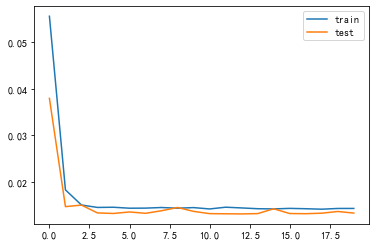

In [9]:
plt.plot(history.history["loss"],label="train")
plt.plot(history.history["val_loss"],label="test")
plt.legend()

In [28]:
X_test.shape

(35039, 1, 8)

In [93]:
# make a prediction
y_pre = model.predict(X_test)
# invert scaling for forecast反归一化
X_test_ori = X_test.reshape((X_test.shape[0], X_test.shape[2])) # 复原成原来的输入格式
print(y_pre.shape, X_test_ori[:, 1:].shape)
inv_y_pre = np.concatenate((y_pre, X_test_ori[:, 1:]), axis=1)

(35039, 1) (35039, 7)


In [94]:
inv_yhat = scaler.inverse_transform(inv_y_pre)

In [95]:
from sklearn.metrics import mean_squared_error
inv_yhat = inv_yhat[:,0]
# 未归一化的的y
inv_y = scaler.inverse_transform(inv_y_pre)
inv_y = inv_y[:,0]
'
# 标签值的反归一化
y_test_inv = y_test.reshape((y_test.shape[0],1))
y_test_inv = scaler.inverse_transform(np.concatenate((y_test,X_test_ori[:,1:]),axis=1))
y_test_inv = y_test_inv[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_inv, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.150
